In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from dataloader import get_dataloaders
from models.msdnet import MSDNet
from utils import parse_args
from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict

import pandas as pd
import glob
import os
import shutil

from tqdm import tqdm
import pickle

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 0.1 ImageNet extract and folder setup

In [2]:
# images = glob.glob("data/image_net/valid/*.JPEG")

# labels = pd.read_csv('data/image_net/valid/labels_kaggle_with_names.csv', index_col=0)
# labels.columns = ["image_id", "label", "name"]

# # make class folders (with names)
# for _name in labels["name"].unique():
#     try:
#         os.mkdir(f'data/image_net/valid/{_name}')
#     except Exception as e:
#         print(i)
#         print(e)

# # extract number from the image name, e.g. 'data/image_net/valid/ILSVRC2012_val_00013964.JPEG' -> 13964
# images_id = [int(image.split('/')[-1].split('.')[0].split('_')[-1]) for image in images]

# # move images to folder labels
# for id, path in zip(images_id, images):
#     label = labels[labels["image_id"] == id]["name"].values[0]
#     name = path.split('/')[-1]
#     try:
#         shutil.move(f'data/image_net/valid/{name}', f'data/image_net/valid/{label}/{name}')
#     except Exception as e:
#         print(id)
#         print(e)

In [3]:
# for label in range(1, 1001):
#     images = glob.glob(f"data/image_net/valid/{label}/*.JPEG")
#     images_id = [int(image.split('/')[-1].split('.')[0].split('_')[-1]) for image in images]
#     for id, path in zip(images_id, images):
#         name = path.split('/')[-1]
#         try:
#             shutil.move(f'data/image_net/valid/{label}/{name}', f'data/image_net/valid/{name}')
#         except Exception as e:
#             print(id)
#             print(e)

In [4]:
# for label in range(1, 1001):
#     os.rmdir(f'/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/data/image_net/valid/{label}')

# 0 load logits

In [5]:
# logits, targets, ARGS = get_logits_targets_image_net()
with open(f'output/ImageNet.p', 'rb') as f:
    data = pickle.load(f)
logits, targets, ARGS = data

In [6]:
# sanity check for labels
for i in range(10):
    print(torch.mode(targets[50*i:50*(i+1)]).values, torch.mode(torch.argmax(logits, dim=2)[-1, :][50*i:50*(i+1)]).values)

tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(2) tensor(2)
tensor(3) tensor(3)
tensor(4) tensor(4)
tensor(5) tensor(5)
tensor(6) tensor(6)
tensor(7) tensor(7)
tensor(8) tensor(8)
tensor(9) tensor(9)


In [ ]:
# with open(f'output/{ARGS.data}.p', 'wb') as f:
#     pickle.dump((logits, targets, ARGS), f)
#     f.close()

# 1 Anytime Performance

In [6]:
L = len(logits)
N = logits.shape[1]

In [7]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [6]:
[round(float(x), 4) for x in acc]

[0.5663, 0.6514, 0.6842, 0.6977, 0.7134]

In [11]:
[round(x, 4) for x in modal_probs_decreasing(preds, probs, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

[84.326, 69.972, 51.72, 38.066, 20.518, 14.666, 8.336, 2.024]

In [12]:
probs = torch.softmax(logits, dim=2)
probs_de = probs.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5.])[:, None, None]
preds_de = {i: torch.argmax(probs_de, dim=2)[i, :] for i in range(L)}
acc_de = [(targets == preds_de[i]).sum() / len(targets) for i in range(L)]

In [13]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5.])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [14]:
probs_ovr = ovr_likelihood(logits)
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets == preds_ovr[i]).sum() / len(targets) for i in range(L)]

In [15]:
probs_ovr = ovr_likelihood(logits)
probs_poe_ovr = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets == preds_poe_ovr[i]).sum() / len(targets) for i in range(L)]

In [16]:
probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted(logits))
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [17]:
# probs_poe_ovr_break_ties_thres_5 = torch.tensor(f_probs_ovr_poe_logits_weighted(logits, threshold=5.0))
# preds_poe_ovr_break_ties_thres_5 = {i: torch.argmax(probs_poe_ovr_break_ties_thres_5, dim=2)[i, :] for i in range(L)}
# acc_poe_ovr_break_ties_thres_5 = [(targets == preds_poe_ovr_break_ties_thres_5[i]).sum() / len(targets) for i in range(L)]

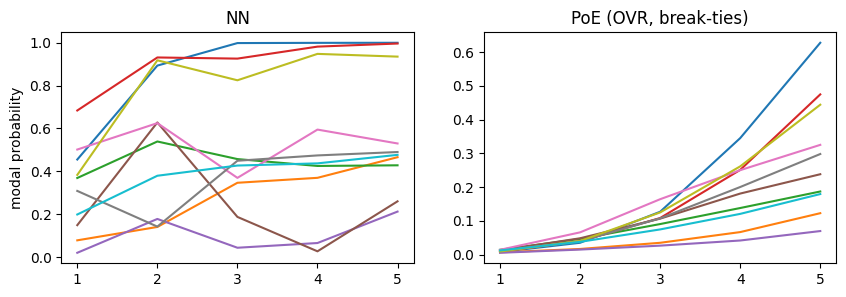

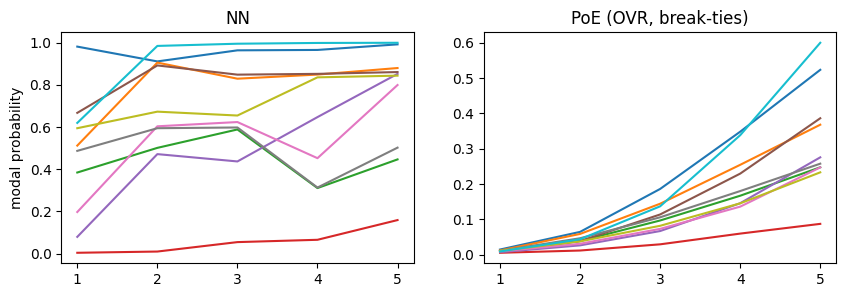

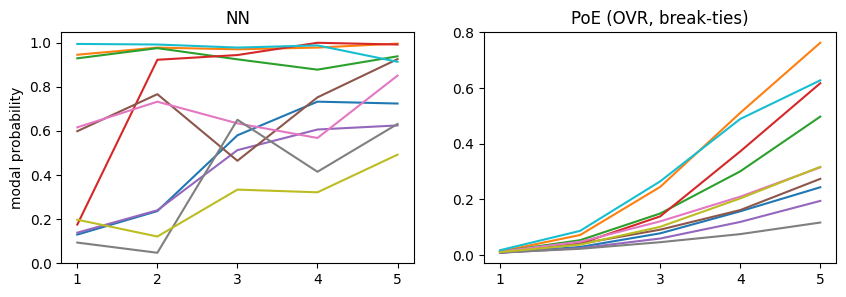

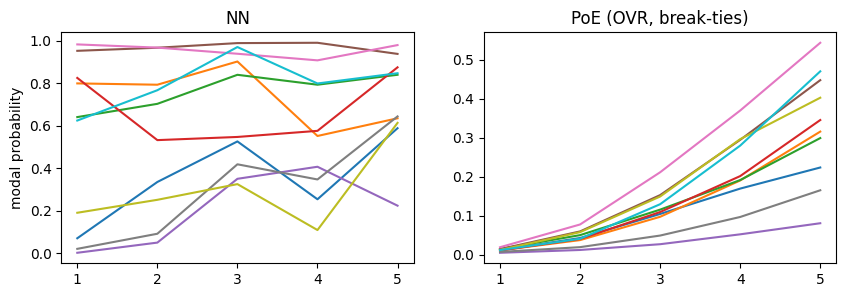

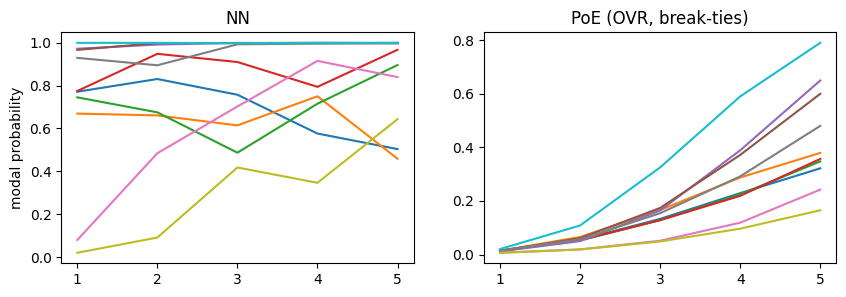

In [16]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    samples = random.sample(range(N), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('NN')
    ax[1].set_title('PoE (OVR, break-ties)')
    ax[0].set_ylabel('modal probability')
    plt.show()

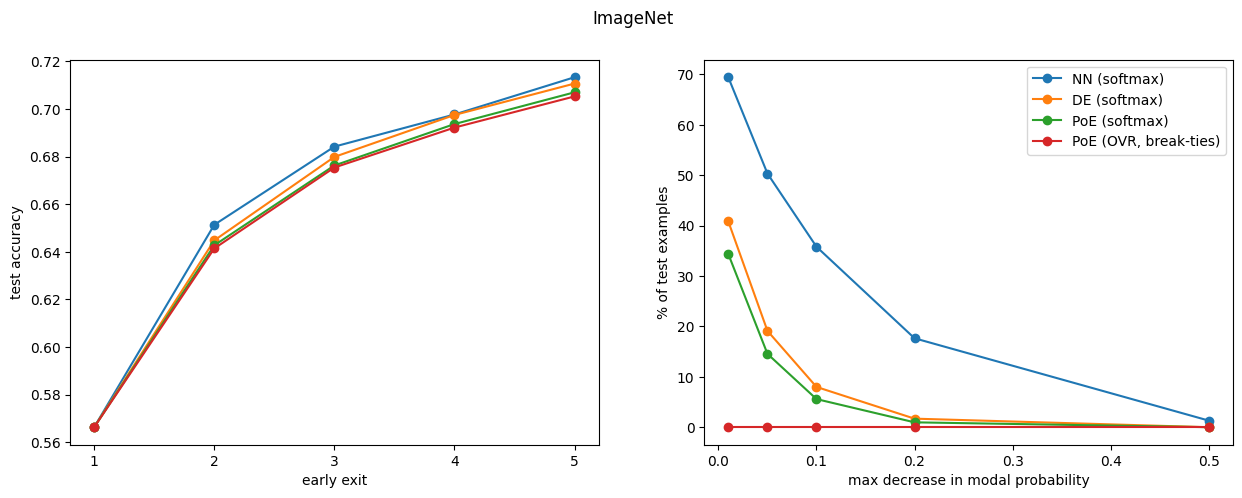

In [17]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(early_exits, acc, label='NN (softmax)', marker='o',)
ax[0].plot(early_exits, acc_de, label='DE (softmax)', marker='o')
ax[0].plot(early_exits, acc_poe, label='PoE (softmax)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (OVR, break-ties)', marker='o')
# ax[0].plot(early_exits, acc_poe_ovr, label='PoE (OVR)', marker='o')
ax[0].set_xlabel('early exit')
ax[0].set_ylabel('test accuracy')
ax[0].set_xticks([1., 2., 3., 4., 5.], [1, 2, 3, 4, 5])

for _preds, _probs, label in [
                            (preds, probs, 'NN (softmax)'), 
                            (preds_de, probs_de, 'DE (softmax)'), 
                            (preds_poe, probs_poe, 'PoE (softmax)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                            # (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            # (preds_ovr_break_ties, probs_ovr_break_ties, 'NN (OVR, break-ties)'),
                            # (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle('ImageNet')
plt.show()

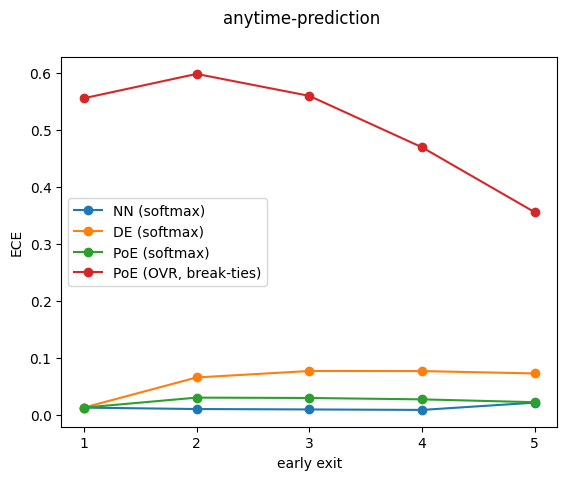

In [18]:
early_exits = [i + 1 for i in range(len(acc))]
for _probs, label in [
                      (probs, 'NN (softmax)'),  
                      (probs_de, 'DE (softmax)'), 
                      (probs_poe, 'PoE (softmax)'),
                      # (probs_poe_ovr, 'PoE (OVR)'),
                      (probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                      # (probs_poe_ovr_break_ties_thres_5, 'PoE (OVR, break-ties, thres=5)'),
                      # (probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                      ]:
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    plt.plot(early_exits, ece, marker='o', label=label)
plt.legend()
plt.xlabel('early exit')
plt.ylabel('ECE')
plt.xticks([1., 2., 3., 4., 5.], [1, 2, 3, 4, 5])

plt.suptitle('anytime-prediction')
plt.show()

In [19]:
(torch.stack(acc)[1:] / torch.stack(acc)[:-1]) - 1.

tensor([0.1502, 0.0504, 0.0197, 0.0224])

# 2 Predictive set size

In [20]:
N = len(targets)
THRES = [0., 1., 2., 3., 4., 5.]

In [21]:
thres_dict = {}
for thres in tqdm(THRES):
    _probs = torch.tensor(f_probs_ovr_poe_logits_weighted(logits, threshold=thres))
    _preds = {i: torch.argmax(_probs, dim=2)[i, :] for i in range(L)}
    _acc = [(targets == _preds[i]).sum() / len(targets) for i in range(L)]

    groud_truth_coverage = {l: 0 for l in range(L)}
    predictive_set_size = {l: [] for l in range(L)}
    for l in range(L):
        for n in range(N):
            if _probs[l, n, targets[n]] > 0.:
                groud_truth_coverage[l] += 1
            predictive_set_size[l].append((_probs[l, n, :] > 0).sum())

    predictive_set_size = {l: torch.stack(sizes, dim=0) for l, sizes in predictive_set_size.items()}
    predictive_set_size_mean = {l: sizes.numpy().mean() for l, sizes in predictive_set_size.items()}
    groud_truth_coverage_pct = {l: (x / N) for l, x in groud_truth_coverage.items()}
    thres_dict[thres] = (groud_truth_coverage_pct, predictive_set_size_mean, _acc)

 50%|█████     | 3/6 [00:39<00:39, 13.08s/it]/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:114: RuntimeWarning: invalid value encountered in divide
  probs = (probs / np.repeat(probs.sum(axis=2)[:, :, np.newaxis], C, axis=2))
100%|██████████| 6/6 [01:20<00:00, 13.39s/it]


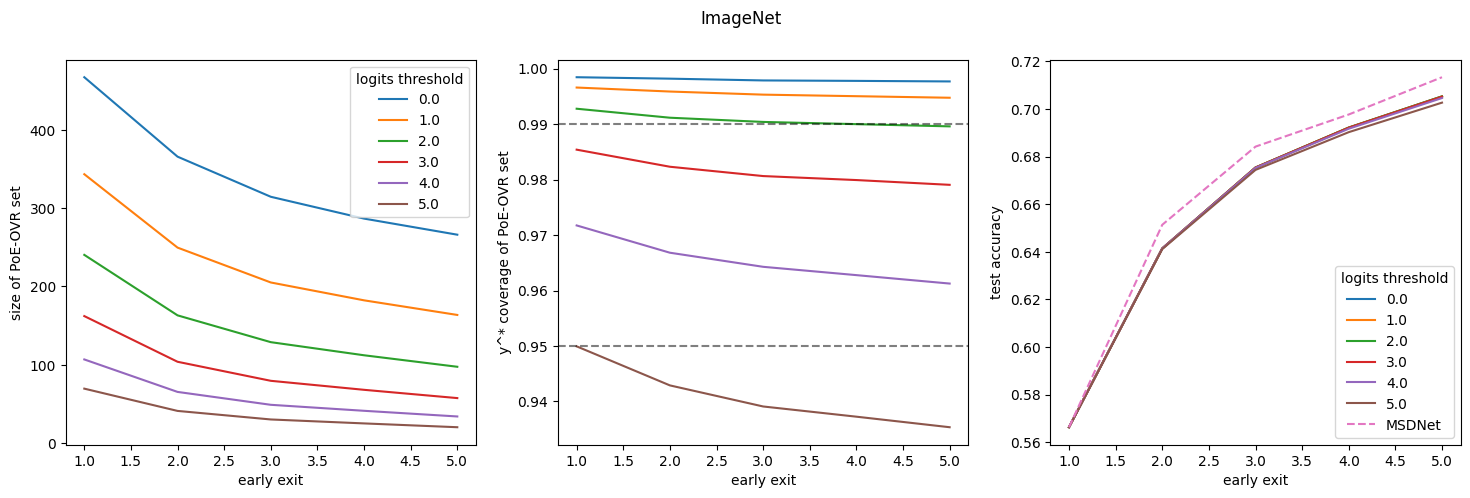

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for thres in THRES:
    ax[0].plot([x + 1 for x in thres_dict[thres][1].keys()], list(thres_dict[thres][1].values()), label=thres)
    ax[1].plot([x + 1 for x in thres_dict[thres][0].keys()], list(thres_dict[thres][0].values()), label=thres)
    ax[2].plot([x + 1 for x in thres_dict[thres][0].keys()], thres_dict[thres][2], label=thres)
ax[2].plot([x + 1 for x in thres_dict[thres][0].keys()], acc, label='MSDNet', linestyle='--')
ax[0].legend(title='logits threshold')
ax[2].legend(title='logits threshold')
ax[0].set_ylabel('size of PoE-OVR set')
ax[1].set_ylabel('y^* coverage of PoE-OVR set')
ax[2].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')
ax[1].set_xlabel('early exit')
ax[2].set_xlabel('early exit')

ax[1].axhline(y=0.99, color='black', linestyle='--', alpha=0.5)
ax[1].axhline(y=0.95, color='black', linestyle='--', alpha=0.5)
plt.suptitle(ARGS.data)
plt.show()

# 3 Generalized PoE

In [8]:
# probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=np.array([1. ,2., 3., 4., 5.])))
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.array([1. ,2., 3., 4., 5.]) / 5.)) * T)
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [9]:
[round(float(x), 4) for x in acc_poe_ovr_break_ties_generalized]

[0.5663, 0.6508, 0.6867, 0.7022, 0.7138]

In [14]:
[round(x, 4) for x in modal_probs_decreasing(preds_poe_ovr_break_ties_generalized, 
                                            probs_poe_ovr_break_ties_generalized, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

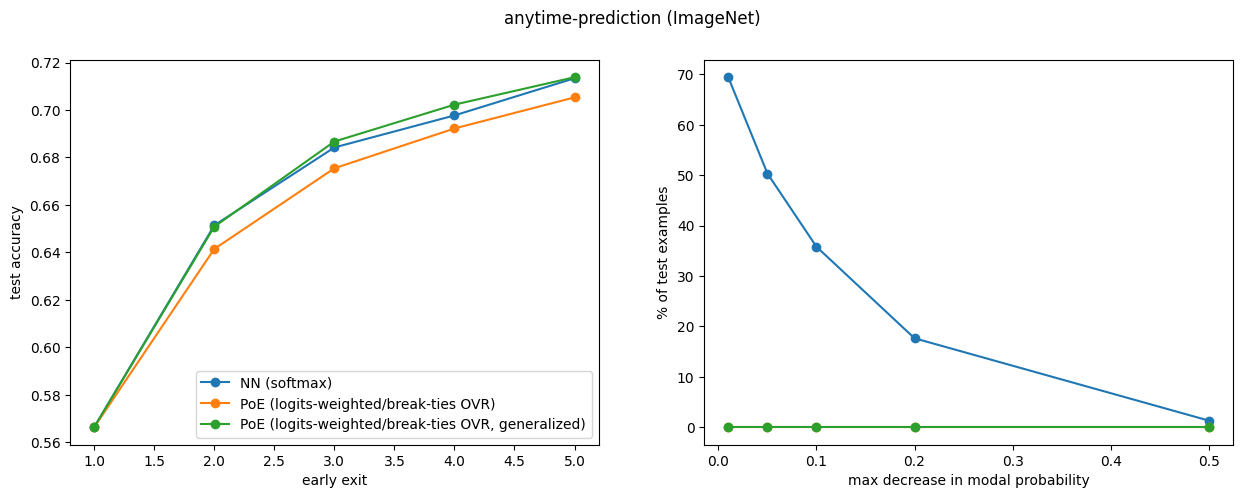

In [24]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='NN (softmax)', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (logits-weighted/break-ties OVR)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties_generalized, label='PoE (logits-weighted/break-ties OVR, generalized)', marker='o')
ax[0].legend()
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, 'NN (softmax)'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (logits-weighted/break-ties OVR)'),
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'PoE (logits-weighted/break-ties OVR, generalized)'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()

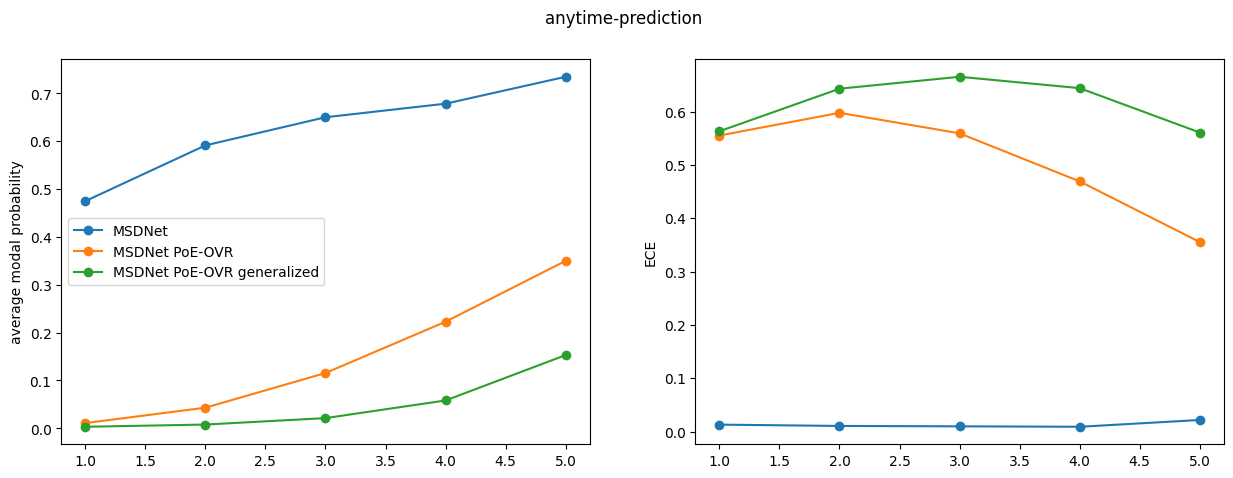

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
early_exits = [i + 1 for i in range(len(acc))]
for _preds, _probs, label in [
                            (preds, probs, 'MSDNet'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'MSDNet PoE-OVR'),
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'MSDNet PoE-OVR generalized'),
                            ]:
    modal_probs = modal_probs_average(_preds, _probs, L, N=N)
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[0].plot(early_exits, modal_probs.numpy(), marker='o', label=label)
    ax[1].plot(early_exits, ece, marker='o', label=label)
ax[0].legend()
ax[0].set_ylabel('average modal probability')
ax[1].set_ylabel('ECE')


plt.suptitle('anytime-prediction')
plt.show()

# 4 Temperature scaling

In [26]:
T_ARR = [ 0.2, 0.5, 1., 2., 5.]
PROBS_NAME = ['MSDNet', 'MSDNet PoE-OVR']
PROBS = [probs, probs_poe_ovr_break_ties_generalized]

In [27]:
scaled_dict = get_scale_probs(PROBS_NAME, PROBS, T_ARR, targets, C=ARGS.num_classes, L=L)

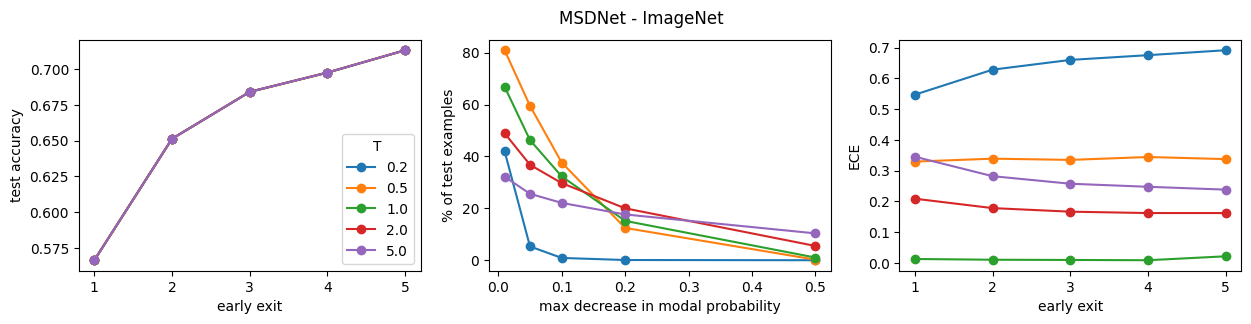

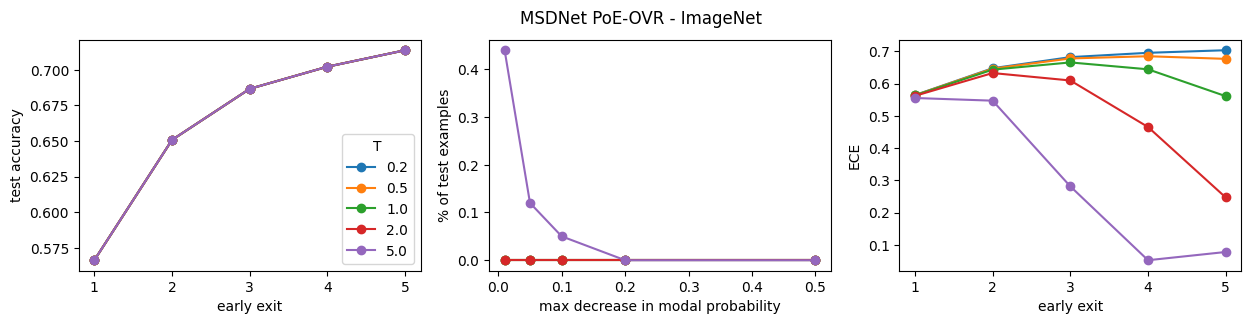

In [28]:
for prob_name in PROBS_NAME:
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    for i, T in enumerate(T_ARR):
        _probs, _preds, _acc = scaled_dict[prob_name][T]
        ax[0].plot(list(range(1, L + 1)), _acc, label=T, marker='o')
        ax[0].set_xlabel('early exit')
        ax[0].set_ylabel('test accuracy')
        ax[0].legend(title='T')

        modal_probs = modal_probs_decreasing(_preds, _probs, L)
        ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

        ax[1].set_xlabel('max decrease in modal probability')
        ax[1].set_ylabel('% of test examples')

        ece = []
        for l in range(L):
            ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
        ax[2].plot(list(range(1, L + 1)), ece, marker='o', label=label)
        ax[2].set_xlabel('early exit')
        ax[2].set_ylabel('ECE')
        
    plt.suptitle(f'{prob_name} - {ARGS.data}')
    plt.show()

# 5 Sort images w.r.t. entropy/MSP (hard vs easy examples)

In [10]:
val_loader = get_image_net_val_loader(ARGS, normalize=False)

LABEL = 0

label_ids = np.where(targets.numpy() == LABEL)[0]
val_images, val_targets = next(iter(val_loader))
val_images, val_targets = val_images[label_ids], val_targets[label_ids]

In [28]:
l = 0
easy_vs_hard = probs[l, label_ids, :].max(dim=1).values.argsort().numpy()
easy_vs_hard_poe_ovr_break_ties_generalized = probs_poe_ovr_break_ties_generalized[l, label_ids, :].max(dim=1).values.argsort().numpy()

In [29]:
easy_vs_hard

array([ 2, 32, 35, 36, 31, 29, 27,  0, 20,  1, 10, 21,  4, 48, 25, 42,  6,
       19, 26, 46, 41,  3,  7, 43, 37, 45, 38,  5, 23, 34,  8, 13,  9, 18,
       14, 22, 39, 44, 30, 40, 49, 11, 33, 24, 47, 28, 12, 15, 17, 16])

In [30]:
probs[l, label_ids, :].max(dim=1).values.sort().values.numpy()

array([0.08368771, 0.12604095, 0.15075223, 0.2958613 , 0.30850706,
       0.44555655, 0.45077038, 0.47960818, 0.52567804, 0.56073606,
       0.6132172 , 0.6866294 , 0.7437559 , 0.81484747, 0.8262277 ,
       0.84025866, 0.8433354 , 0.8478345 , 0.8629197 , 0.8676097 ,
       0.9237862 , 0.92554903, 0.9289144 , 0.9315646 , 0.94988054,
       0.9577057 , 0.96246433, 0.9627378 , 0.96640456, 0.96865654,
       0.97582245, 0.97702163, 0.9788786 , 0.985686  , 0.9904587 ,
       0.9917286 , 0.9941869 , 0.994693  , 0.9954347 , 0.9973239 ,
       0.9980919 , 0.99861765, 0.99886227, 0.9989422 , 0.9989735 ,
       0.9991543 , 0.9993623 , 0.9995541 , 0.9996427 , 0.99965656],
      dtype=float32)

In [31]:
((preds[l][label_ids] == targets[label_ids])[easy_vs_hard]).type(torch.uint8)

tensor([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1], dtype=torch.uint8)

In [32]:
easy_vs_hard_poe_ovr_break_ties_generalized

array([ 2, 35, 32, 27, 31, 25, 42, 20, 29, 19,  4, 39, 37, 45, 41, 36,  3,
       46, 10, 33, 28, 21,  6,  5, 48, 43,  0, 38,  1,  7, 30, 34, 14, 47,
       11,  9, 40, 17, 49,  8, 16, 13, 12, 15, 23, 26, 18, 22, 44, 24])

In [33]:
probs_poe_ovr_break_ties_generalized[l, label_ids, :].max(dim=1).values.sort().values.numpy()

array([0.00274783, 0.00280792, 0.0028232 , 0.00282505, 0.00287534,
       0.002894  , 0.00290375, 0.00292461, 0.00301385, 0.00304237,
       0.00307279, 0.0030787 , 0.00309628, 0.00309685, 0.00311136,
       0.00311743, 0.00312664, 0.00312852, 0.0031808 , 0.00321531,
       0.0032202 , 0.00322164, 0.00323174, 0.00323717, 0.00324612,
       0.00325735, 0.00325942, 0.00326826, 0.00330614, 0.00332518,
       0.00334835, 0.00334955, 0.00335218, 0.00335834, 0.00335911,
       0.00338288, 0.00338372, 0.00339372, 0.00339438, 0.00340015,
       0.00343594, 0.0034898 , 0.00350737, 0.00352034, 0.00357223,
       0.00359341, 0.00360267, 0.00361041, 0.00368311, 0.00378786],
      dtype=float32)

In [34]:
((preds_poe_ovr_break_ties_generalized[l][label_ids] == targets[label_ids])[easy_vs_hard_poe_ovr_break_ties_generalized]).type(torch.uint8)

tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1], dtype=torch.uint8)

In [1]:
# for i in range(len(easy_vs_hard)):
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].imshow(val_images[easy_vs_hard[i], :, :, :].cpu().permute(1, 2, 0))
#     ax[0].axis('off')
#     ax[0].set_title('base')
#     ax[1].imshow(val_images[easy_vs_hard_poe_ovr_break_ties_generalized[i], :, :, :].cpu().permute(1, 2, 0))
#     ax[1].axis('off')
#     ax[1].set_title('PoE-OVR')
#     plt.suptitle(f'hardness ranking: {i + 1}')
#     plt.show()

# 6 nr. of early exits that equal final prediction

In [15]:
# preds_ = torch.stack([preds[l] == preds[L - 1] for l in range(L - 1)], dim=0).int().sum(dim=0).numpy()
preds_ = torch.stack([preds[l] == targets for l in range(L)], dim=0).int().sum(dim=0).numpy()
preds_unique, preds_counts = np.unique(preds_, return_counts=True)

In [16]:
# preds_poe_ovr_ = torch.stack([preds_poe_ovr_break_ties_generalized[l] == preds_poe_ovr_break_ties_generalized[L - 1] for l in range(L - 1)], dim=0).int().sum(dim=0).numpy()
preds_poe_ovr_ = torch.stack([preds_poe_ovr_break_ties_generalized[l] == targets for l in range(L)], dim=0).int().sum(dim=0).numpy()
preds_poe_ovr_unique, preds_poe_ovr_counts = np.unique(preds_poe_ovr_, return_counts=True)

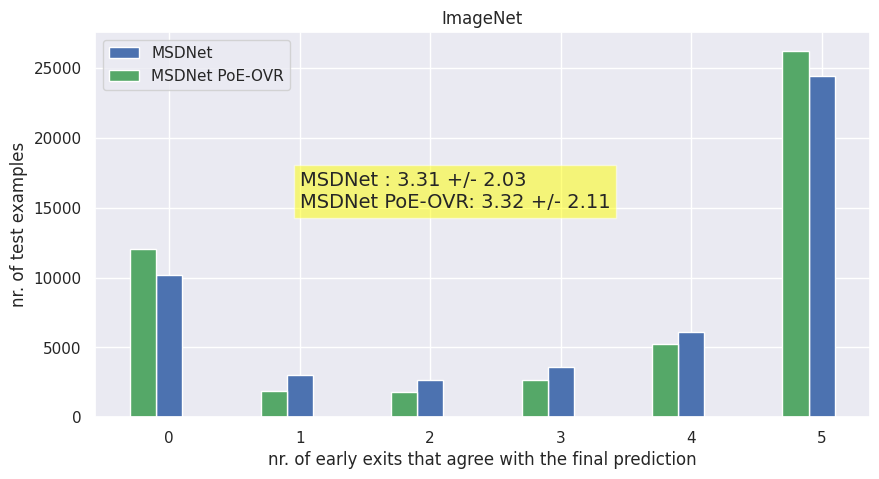

In [17]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(preds_unique, preds_counts, label='MSDNet', width=0.2, color='b', align='center',)
ax.bar(preds_poe_ovr_unique - 0.2, preds_poe_ovr_counts, label='MSDNet PoE-OVR', width=0.2, color='g', align='center')
# plt.xticks(x, [1, 2, 3])
plt.legend()
plt.xlabel('nr. of early exits that agree with the final prediction')
plt.ylabel('nr. of test examples')
plt.text(1, 15000, f'MSDNet : {preds_.mean():.2f} +/- {preds_.std():.2f}\nMSDNet PoE-OVR: {preds_poe_ovr_.mean():.2f} +/- {preds_poe_ovr_.std():.2f}', fontsize = 14, 
         bbox = dict(facecolor = 'yellow', alpha = 0.5))
plt.title(f'{ARGS.data}')
plt.show()

In [18]:
scipy.stats.wilcoxon(preds_, preds_poe_ovr_, alternative='less')

WilcoxonResult(statistic=16982235.5, pvalue=0.002965656760104045)

# 7 Changing your mind

In [11]:
preds_change = torch.stack([x for x in preds.values()], dim=0)
preds_change = (L - 1) - (preds_change[1:, :] == preds_change[:-1, :]).sum(dim=0).numpy()
preds_change_unique, preds_change_counts = np.unique(preds_change, return_counts=True)

In [12]:
preds_poe_ovr_change = torch.stack([x for x in preds_poe_ovr_break_ties_generalized.values()], dim=0)
preds_poe_ovr_change = (L - 1) - (preds_poe_ovr_change[1:, :] == preds_poe_ovr_change[:-1, :]).sum(dim=0).numpy()
preds_poe_ovr_change_unique, preds_poe_ovr_change_counts = np.unique(preds_poe_ovr_change, return_counts=True)

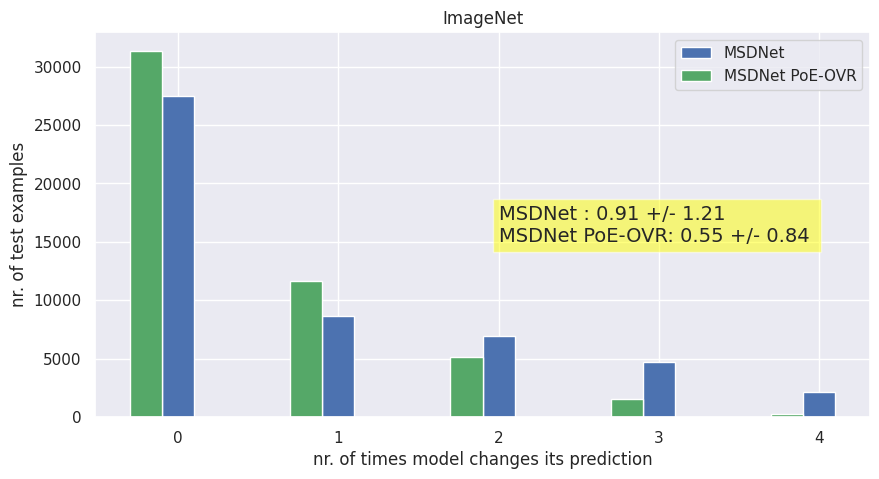

In [15]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(preds_change_unique, preds_change_counts, label='MSDNet', width=0.2, color='b', align='center',)
ax.bar(preds_poe_ovr_change_unique - 0.2, preds_poe_ovr_change_counts, label='MSDNet PoE-OVR', width=0.2, color='g', align='center')
# plt.xticks(x, [1, 2, 3])
plt.legend()
plt.xlabel('nr. of times model changes its prediction')
plt.ylabel('nr. of test examples')
plt.text(2, 15000, f'MSDNet : {preds_change.mean():.2f} +/- {preds_change.std():.2f} \nMSDNet PoE-OVR: {preds_poe_ovr_change.mean():.2f} +/- {preds_poe_ovr_change.std():.2f} ', fontsize = 14, 
         bbox = dict(facecolor = 'yellow', alpha = 0.5))
plt.title(f'{ARGS.data}')
plt.show()

5

In [12]:
preds_change_targets = torch.stack([x == targets for x in preds.values()], dim=0)
preds_change_targets = preds_change_targets.int().diff(dim=0).numpy()

In [13]:
preds_poe_ovr_change_targets = torch.stack([x == targets for x in preds_poe_ovr_break_ties_generalized.values()], dim=0)
preds_poe_ovr_change_targets = preds_poe_ovr_change_targets.int().diff(dim=0).numpy()

In [14]:
res_dict = change_your_mind_analysis(['base', 'PoE-OvR'], [preds_change_targets, preds_poe_ovr_change_targets], [preds[L - 1], preds_poe_ovr_break_ties_generalized[L - 1]], targets, N)

In [15]:
res_dict

{'base': {'no_change (corr_pred)': 24423,
  'no_change (incorr_pred)': 10193,
  'corr_to_incorr': 7845,
  'incorr_to_corr': 1393,
  'both': 6146},
 'PoE-OvR': {'no_change (corr_pred)': 26267,
  'no_change (incorr_pred)': 12044,
  'corr_to_incorr': 8430,
  'incorr_to_corr': 1240,
  'both': 2019}}

In [22]:
print('% of test cases with good changing-your-mind trajectories')
print('base: ', 100 * (res_dict['base']['no_change (corr_pred)'] + res_dict['base']['incorr_to_corr']) / N)
print('PoE-OvR: ', 100 * (res_dict['PoE-OvR']['no_change (corr_pred)'] + res_dict['PoE-OvR']['incorr_to_corr']) / N)

% of test cases with good changing-your-mind trajectories
base:  51.632
PoE-OvR:  55.014


# 8 Misc

## 8.1 Plot ImageNet

In [29]:
# for j, (x, y) in enumerate(val_loader):
#     # plot test images
#     for i in range(10):
#         plt.imshow(x[i, :, :, :].cpu().permute(1, 2, 0))
#         plt.title(f'{y[i]}')
#         plt.axis('off')
#         plt.show()
#     if j > 1:
#         break